In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability.python.distributions as tfd

In [3]:
archetypes_init = np.array([[1,0],
                  [2,2],
                  [0,1]])

In [4]:
def generate_data (archs, n_points, noise=0.1):
    
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    Y0=np.linalg.norm(data-archs[0],axis=1)
    Y1=np.linalg.norm(data-archs[1],axis=1)
    Y2=np.linalg.norm(data-archs[2],axis=1)
    Y0=Y0/np.max(Y0)
    Y1=Y0/np.max(Y1)
    Y2=Y0/np.max(Y2)
    Y=np.concatenate((np.expand_dims(Y0,axis=1),np.expand_dims(Y1,axis=1),np.expand_dims(Y2,axis=1)),axis=1)
    
    return data, Y

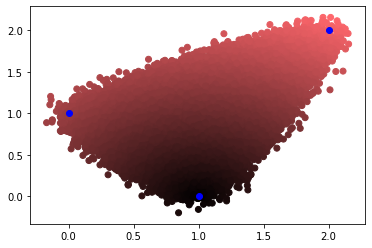

In [5]:
x_train, y_train = generate_data (archetypes_init,100000,noise=0.1)
x_test, y_test = generate_data (archetypes_init,1000,noise=0.1)

data0,data1 = x_train.T
plt.scatter(data0, data1, color=y_train)
data0,data1 = archetypes_init.T
plt.scatter(data0, data1, color='blue')


In [6]:
def get_zfixed ( dim_latent_space ):
    
    z_fixed_t = np.zeros([dim_latent_space, dim_latent_space + 1])

    for k in range(0, dim_latent_space):
        s = 0.0
        for i in range(0, k):
            s = s + z_fixed_t[i, k] ** 2
  
        z_fixed_t[k, k] = np.sqrt(1.0 - s)

        for j in range(k + 1, dim_latent_space + 1):
            s = 0.0
            for i in range(0, k):
                s = s + z_fixed_t[i, k] * z_fixed_t[i, j]

            z_fixed_t[k, j] = (-1.0 / float(dim_latent_space) - s) / z_fixed_t[k, k]
            z_fixed = np.transpose(z_fixed_t)
                    
    return z_fixed


In [7]:
original_dim = x_train.shape [1]
sideinfo_dim = y_train.shape [1]

x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
y_train = np.reshape(y_train, [-1, sideinfo_dim])
y_test = np.reshape(y_test, [-1, sideinfo_dim])


# network parameters
intermediate_dim = 16
batch_size = 1024
latent_dim = 2
simplex_vrtxs = latent_dim + 1
epochs = 100



# encoder
input_x = tfk.Input(shape=(original_dim,), name='encoder_input_x')

x = tfkl.Dense(intermediate_dim, activation='relu')(input_x)
x = tfkl.Dense(intermediate_dim, activation='relu')(x)
A = tfkl.Dense (simplex_vrtxs, activation='linear')(x)
A = tfkl.Dense (simplex_vrtxs, activation=tf.nn.softmax)(A)
B_t = tfkl.Dense (simplex_vrtxs, activation='linear')(x)
B = tf.nn.softmax(tf.transpose(B_t), axis=1)

z_fixed = get_zfixed (latent_dim)
z_fixed = tf.constant (z_fixed, dtype='float32')
mu = tf.matmul(A, z_fixed)
z_pred = tf.matmul(B,mu)
sigma = tfkl.Dense(latent_dim)(x)
t = tfd.Normal(mu,sigma)

input_y = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y')
y = tf.identity(input_y)

encoder = tfk.Model([input_x,input_y], [t.sample(),mu,sigma, tf.transpose(B) ,y], name='encoder')
encoder.summary()



# decoder
latent_inputs = tfk.Input(shape=(latent_dim,), name='z_sampling')
input_y_lat = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y_lat')

x = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = tfkl.Dense(original_dim, activation='linear')(x)
x_hat = tfkl.Dense(original_dim, activation='linear')(x)

y = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
y = tfkl.Dense(intermediate_dim, activation='relu')(y)
y_hat = tfkl.Dense(sideinfo_dim, activation='linear')(y) 

decoder = tfk.Model([latent_inputs,input_y_lat], [x_hat,y_hat], name='decoder')
decoder.summary()



# VAE
encoded = encoder([input_x,input_y])
outputs = decoder( [encoded[0],encoded[-1]])
vae = tfk.Model([input_x,input_y], outputs, name='vae')

reconstruction_loss = tfk.losses.mse (input_x, outputs[0])
class_loss = tfk.losses.mse ( input_y, outputs[1])
archetype_loss = tf.reduce_sum( tfk.losses.mse(z_fixed, z_pred))

kl_loss = 1 + sigma - tf.square(mu) - tf.exp(sigma)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5

lambda_p = 1
nu_p = 1

vae_loss = tf.reduce_mean(nu_p*reconstruction_loss + lambda_p*class_loss + kl_loss + archetype_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


vae.fit([x_train,y_train],  
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,y_test],None))



# archetypes
archetypes,_ = decoder ([z_pred, tf.zeros([3,3])])
get_archtypes = tfk.Model (input_x, [archetypes,z_pred] , name='get_zpred')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           48          encoder_input_x[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            51          dense_1[0][0]                    
____________________________________________________________________________________________

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder_input_y (InputLayer)    [(None, 3)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 multiple             468         encoder_input_x[0][0]            
                                                                 encoder_input_y[0][0]            
__________________________________________________________________________________________________
decoder (Model)                 [(None, 2), (None, 3 459         encoder[1][0]                  

Train on 100000 samples, validate on 1000 samples
Epoch 1/100
100000/100000 [==============================] - 2s 21us/sample - loss: 2.2358 - val_loss: 1.9522
Epoch 2/100
100000/100000 [==============================] - 1s 7us/sample - loss: 1.7166 - val_loss: 1.3228
Epoch 3/100
100000/100000 [==============================] - 1s 8us/sample - loss: 1.0277 - val_loss: 0.7326
Epoch 4/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.4969 - val_loss: 0.3533
Epoch 5/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.2838 - val_loss: 0.2477
Epoch 6/100
100000/100000 [==============================] - 1s 9us/sample - loss: 0.2267 - val_loss: 0.2135
Epoch 7/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.1975 - val_loss: 0.1836
Epoch 8/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.1716 - val_loss: 0.1539
Epoch 9/100
100000/100000 [==============================] - 1s 8us/sample - 

Epoch 75/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0570 - val_loss: 0.0530
Epoch 76/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0559 - val_loss: 0.0535
Epoch 77/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0552 - val_loss: 0.0528
Epoch 78/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0567 - val_loss: 0.0541
Epoch 79/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0571 - val_loss: 0.0538
Epoch 80/100
100000/100000 [==============================] - 1s 11us/sample - loss: 0.0556 - val_loss: 0.0528
Epoch 81/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0548 - val_loss: 0.0524
Epoch 82/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0587 - val_loss: 0.0538
Epoch 83/100
100000/100000 [==============================] - 1s 8us/sample - loss: 0.0568 - val_loss: 0.0535
Epoch 84/

In [8]:
t,mu,sigma, B_t, y = encoder.predict([x_train,y_train])
archetypes_pred, z_pred = get_archtypes(x_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



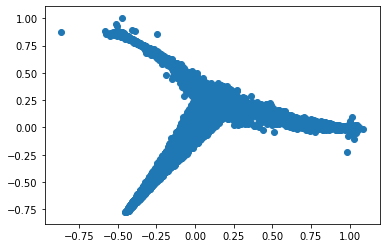

In [9]:
dataX,dataY = t.T
plt.scatter(dataX,dataY)


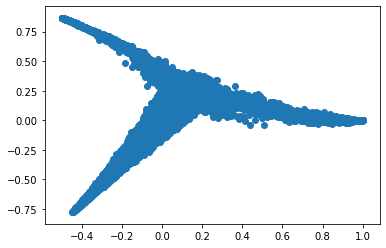

In [10]:
dataX,dataY = mu.T
plt.scatter(dataX,dataY)

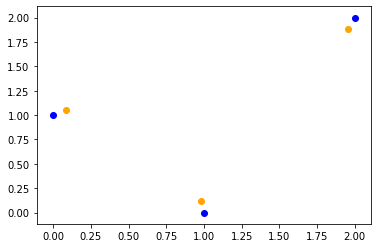

In [11]:
dataX,dataY = archetypes_init.T
plt.scatter(dataX,dataY,color='blue')

dataX,dataY = np.array(archetypes_pred).T
plt.scatter(dataX,dataY,color='orange')


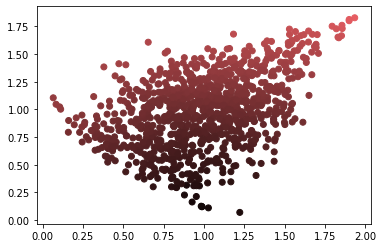

In [12]:
t, y_pred = vae.predict([x_test,y_test])
dataX,dataY = t.T

if (np.min(y_pred)<0):
    y_pred += np.abs(np.min(y_pred))
if (np.min(y_pred)>1):
    y_pred /= np.abs(np.max(y_pred))

plt.scatter(dataX,dataY,color=y_pred)